# Simulation of radar scan patterns using SINC function
### (based on "Introduction to Electronic Warfare" by David L. Adamy)

In [88]:
import math
import numpy as np
import matplotlib.pyplot as plt 

class Coordinates:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

epsilon = 10e-10

#TMTR/RCVR parameters
Gr = 1000
Pt = 100

freq = 3e10
wl = 3 * 10**8 / freq
beamwidth = 90                # Beam width of full main lobe in degrees
radar = Coordinates(0, 0, 0)
radar_az = 0
radar_el = 0                  # TODO
target = Coordinates(10, 10, 10)
time_samples = 10000
t = np.linspace(0, 30, time_samples)

def model_scan(degrees):
    offset_az = (degrees + 180) % 360 - 180
    
    # Calculate relative position of target to radar
    delta = Coordinates(target.x - radar.x, target.y - radar.y, target.z - radar.z)
    distance = (delta.x**2 + delta.y**2 + delta.z**2)**0.5
    
    # Calculate azimuth of target from main lobe
    rel_az = np.arctan2(delta.y, delta.x) * 180 / np.pi
    delta_az = rel_az - offset_az
    
    #TODO
    # Calculate elevation of target from main lobe
    rel_el = np.arcsin(delta.z / distance) * 180 / np.pi #TODO
    
    # Model antenna main and side lobe gain
    A = 100   # Peak main lobe gain
    b = 1     # Exponent
    c = 4    # No. of lobes in half of angular space
    Gt = A * np.sin(math.pi/180 * delta_az * c) / (math.pi/180 * delta_az * c + epsilon)
    Gt = abs(Gt)

    # 1-way power received and beam simulation
    received_power = (Gt * Gr * wl**2) / (4 * np.pi * distance)**2
    
    return received_power

def show_2d(degrees, limits=[-5, 20, -5, 20]):
    x = np.cos(degrees[::38] * np.pi / 180) * 5 + radar.x
    y = np.sin(degrees[::38] * np.pi /180 ) * 5 + radar.y
    colours = np.arange(len(x))
    f = plt.figure()
    f.set_figheight(20)
    f.set_figwidth(30)
    plt.scatter(x, y, c=colours, cmap='viridis', alpha=0.1)
    plt.colorbar()
    plt.scatter(radar.x, radar.z, c = 'blue', label = "Radar")
    plt.scatter(target.x, target.z, c = 'red', label = "Target")
    plt.legend(loc="upper left")
    plt.title("Scan History")
    plt.axis(limits)
    plt.show()
    
def show_power(power):
    
    plt.plot(t, power)
    plt.xlabel("Time")
    plt.ylabel("Power Received")
    plt.title("Observed Power History")
    
    plt.show()

def show_azimuth_history(degrees):
    plt.plot(t, degrees)
    plt.title("Antenna Azimuth over Time")
    plt.show()

# Circular Scan

Circular Scan w/ Static Target


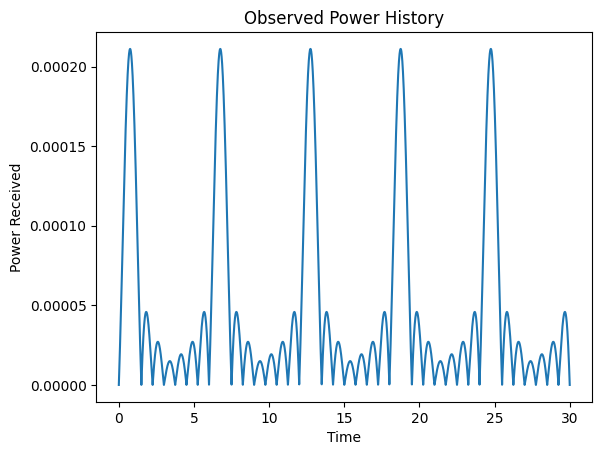

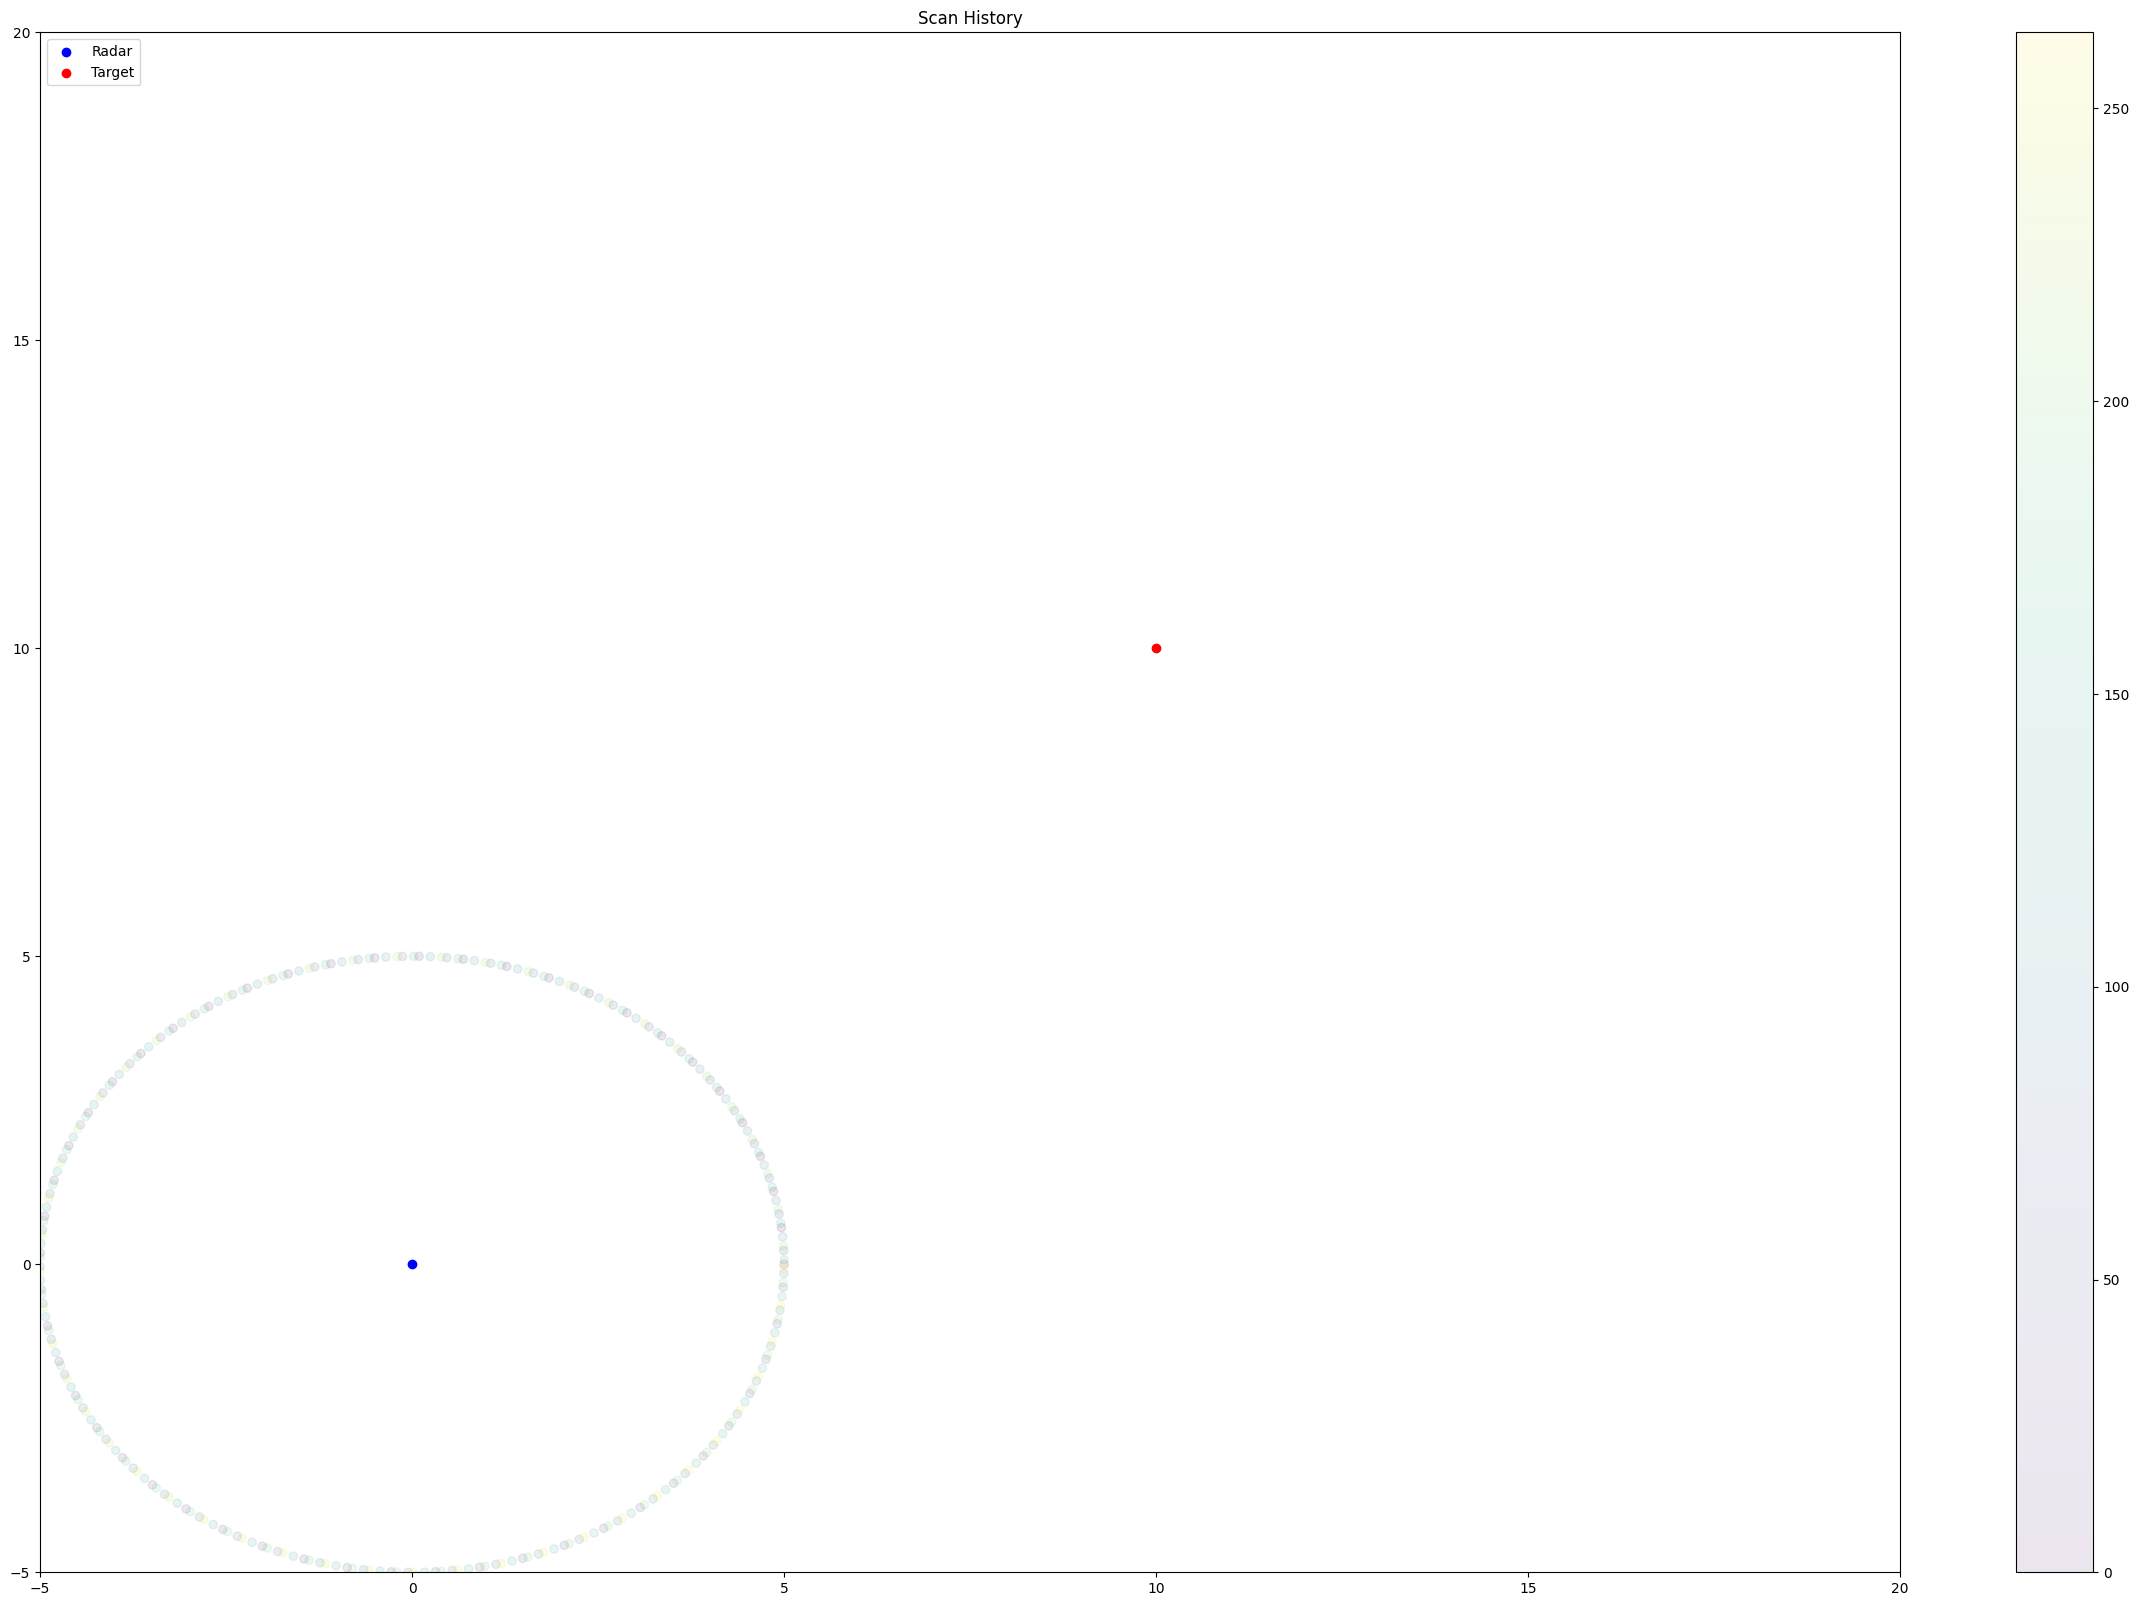

Circular Scan w/ Moving Target


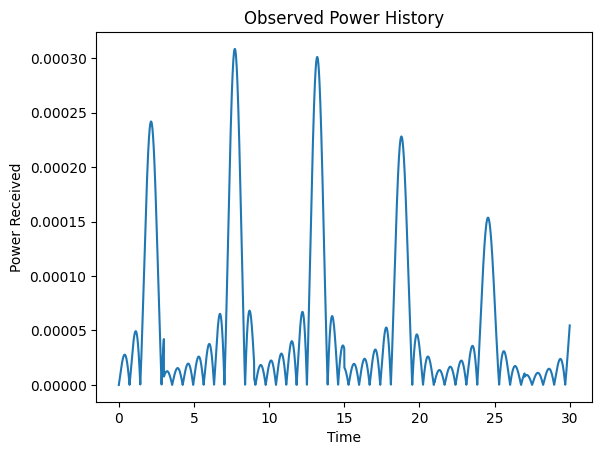

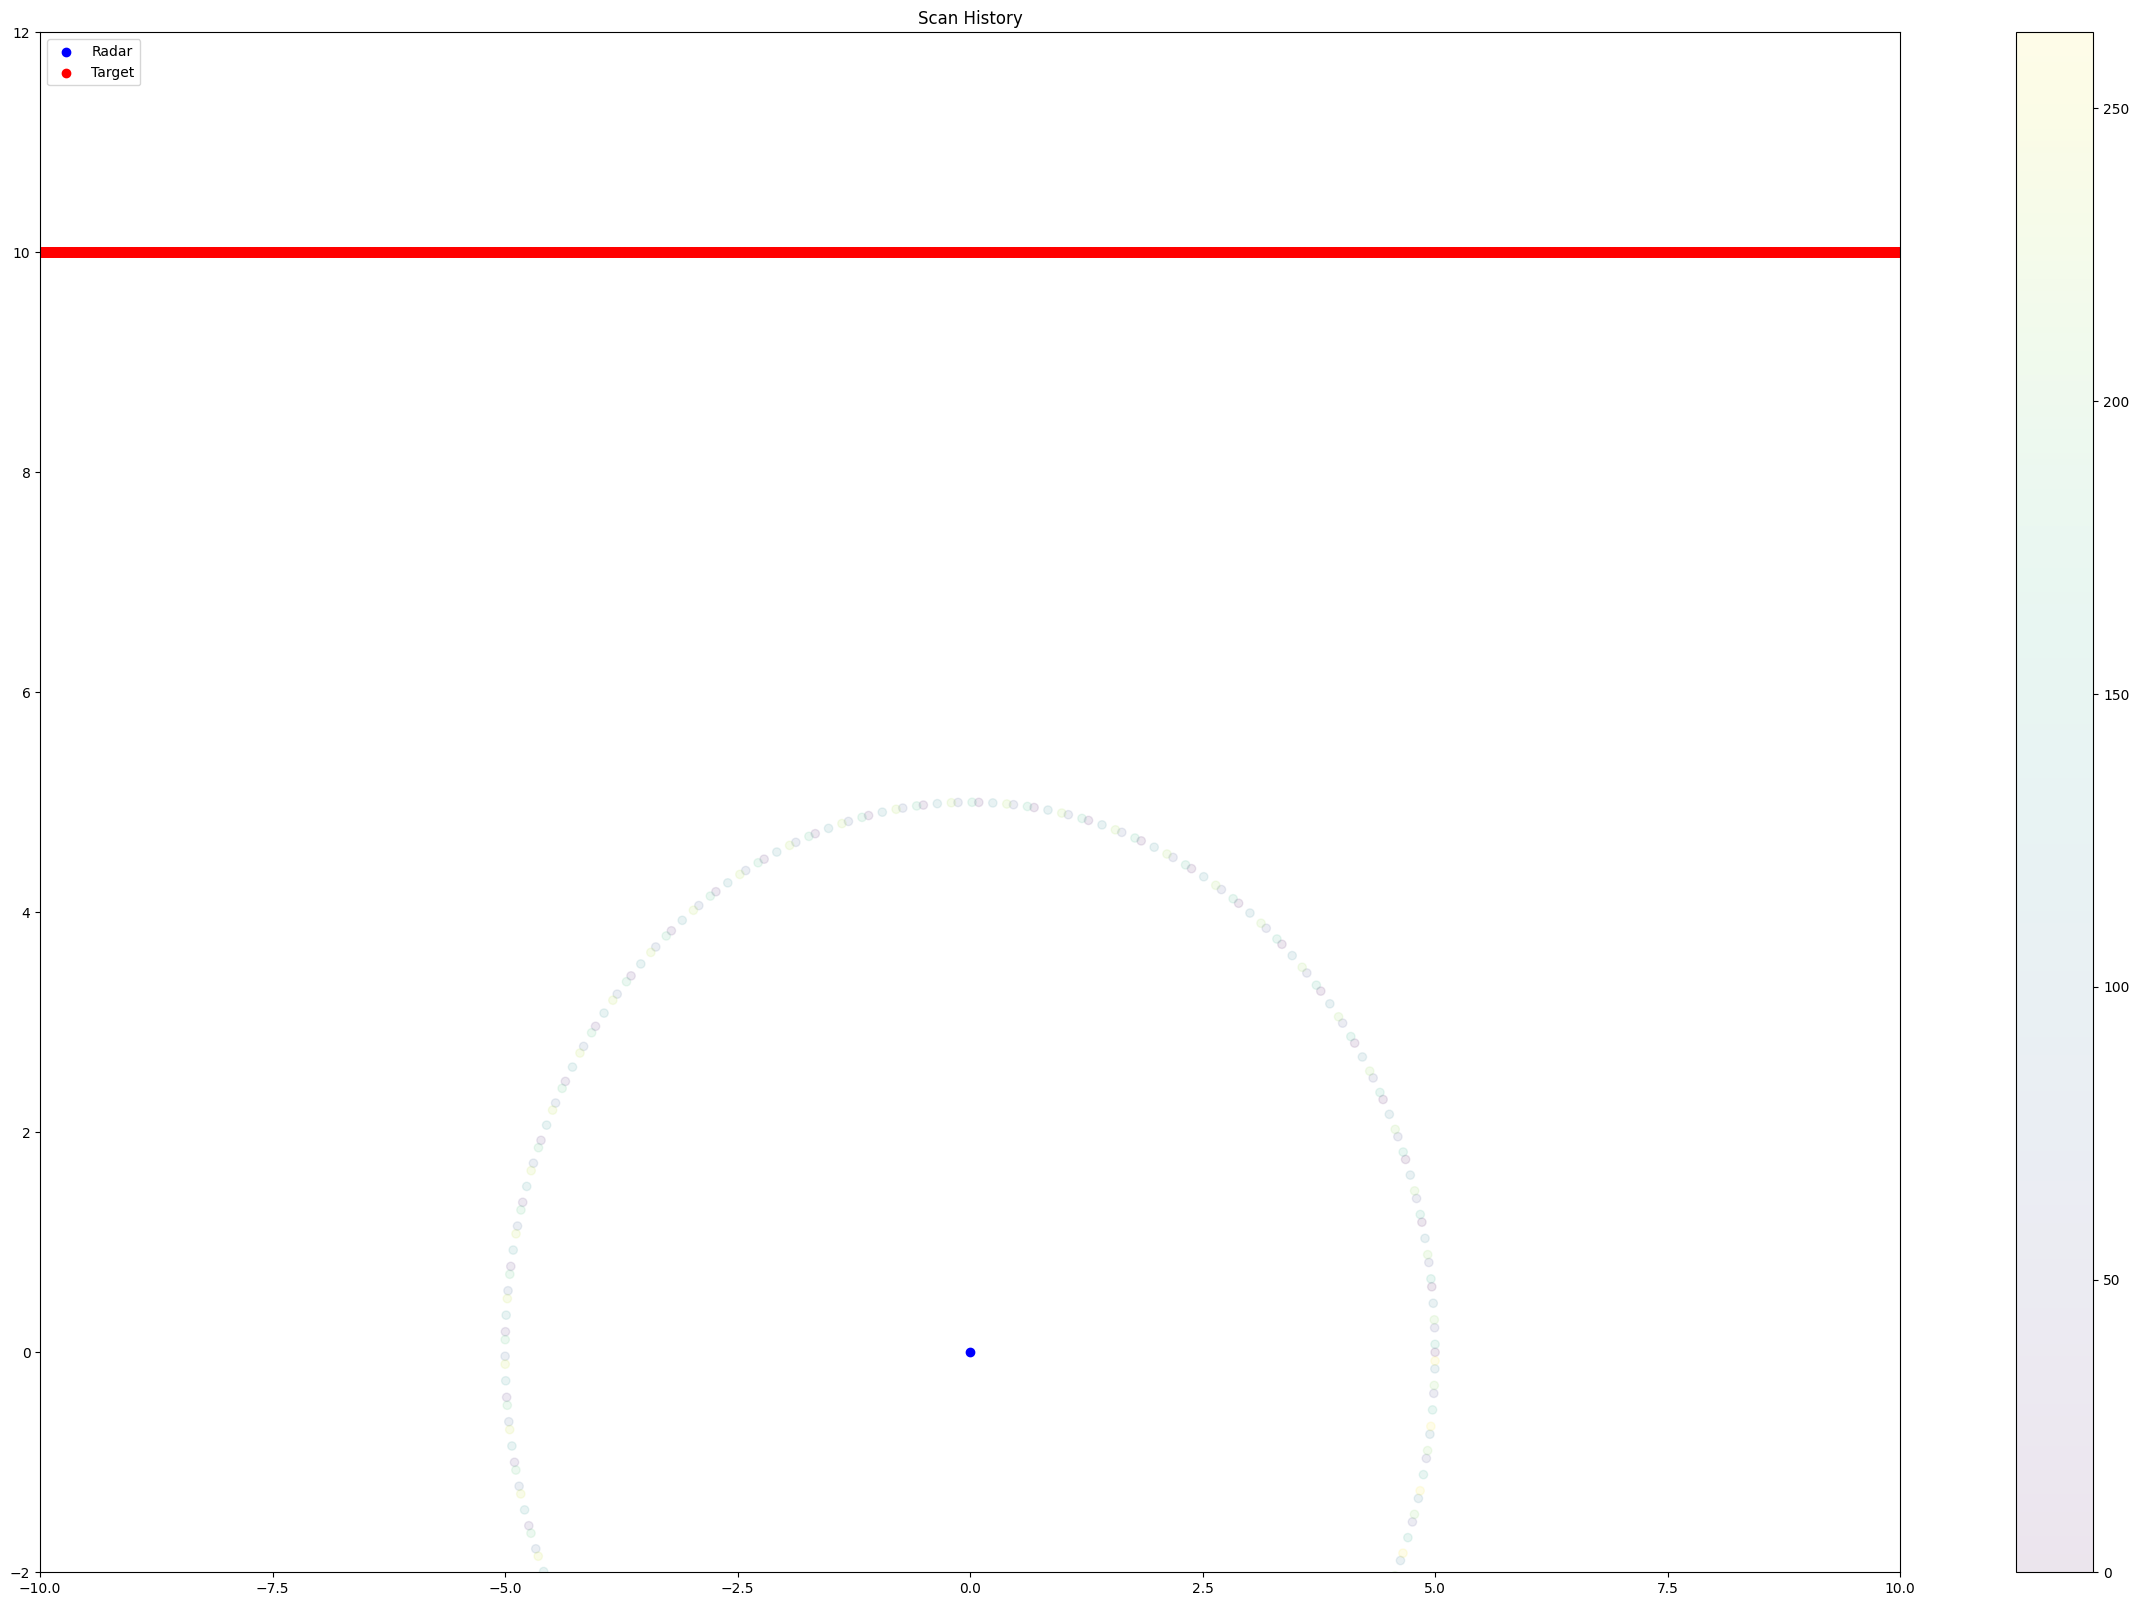

In [89]:
# Static target
degrees = 0
target.x = 10
target.z = 10
az_speed = 60

degrees = 0
degrees = degrees + t * az_speed
power = model_scan(degrees)

print("Circular Scan w/ Static Target")
show_power(power)
show_2d(degrees)

# Moving target
target.x = -10
target.x += t * 1
target.z += t * 0

degrees = 0
degrees = degrees + t * az_speed
power = model_scan(degrees)

print("Circular Scan w/ Moving Target")
show_power(power)
show_2d(degrees, limits=[-10, 10, -2, 12])

# Sector Scan

Sector Scan (180 degrees) w/ Static Target in Scan Sector


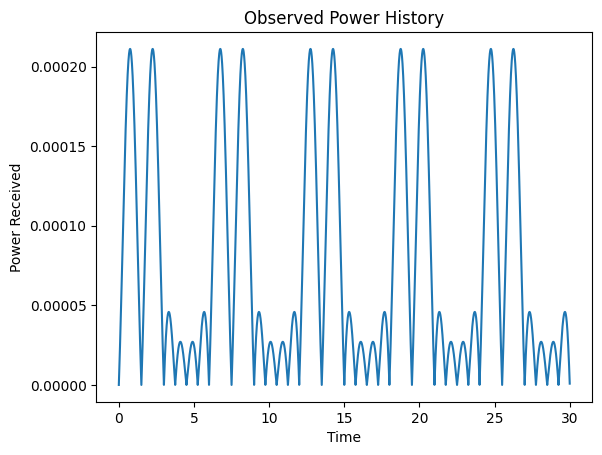

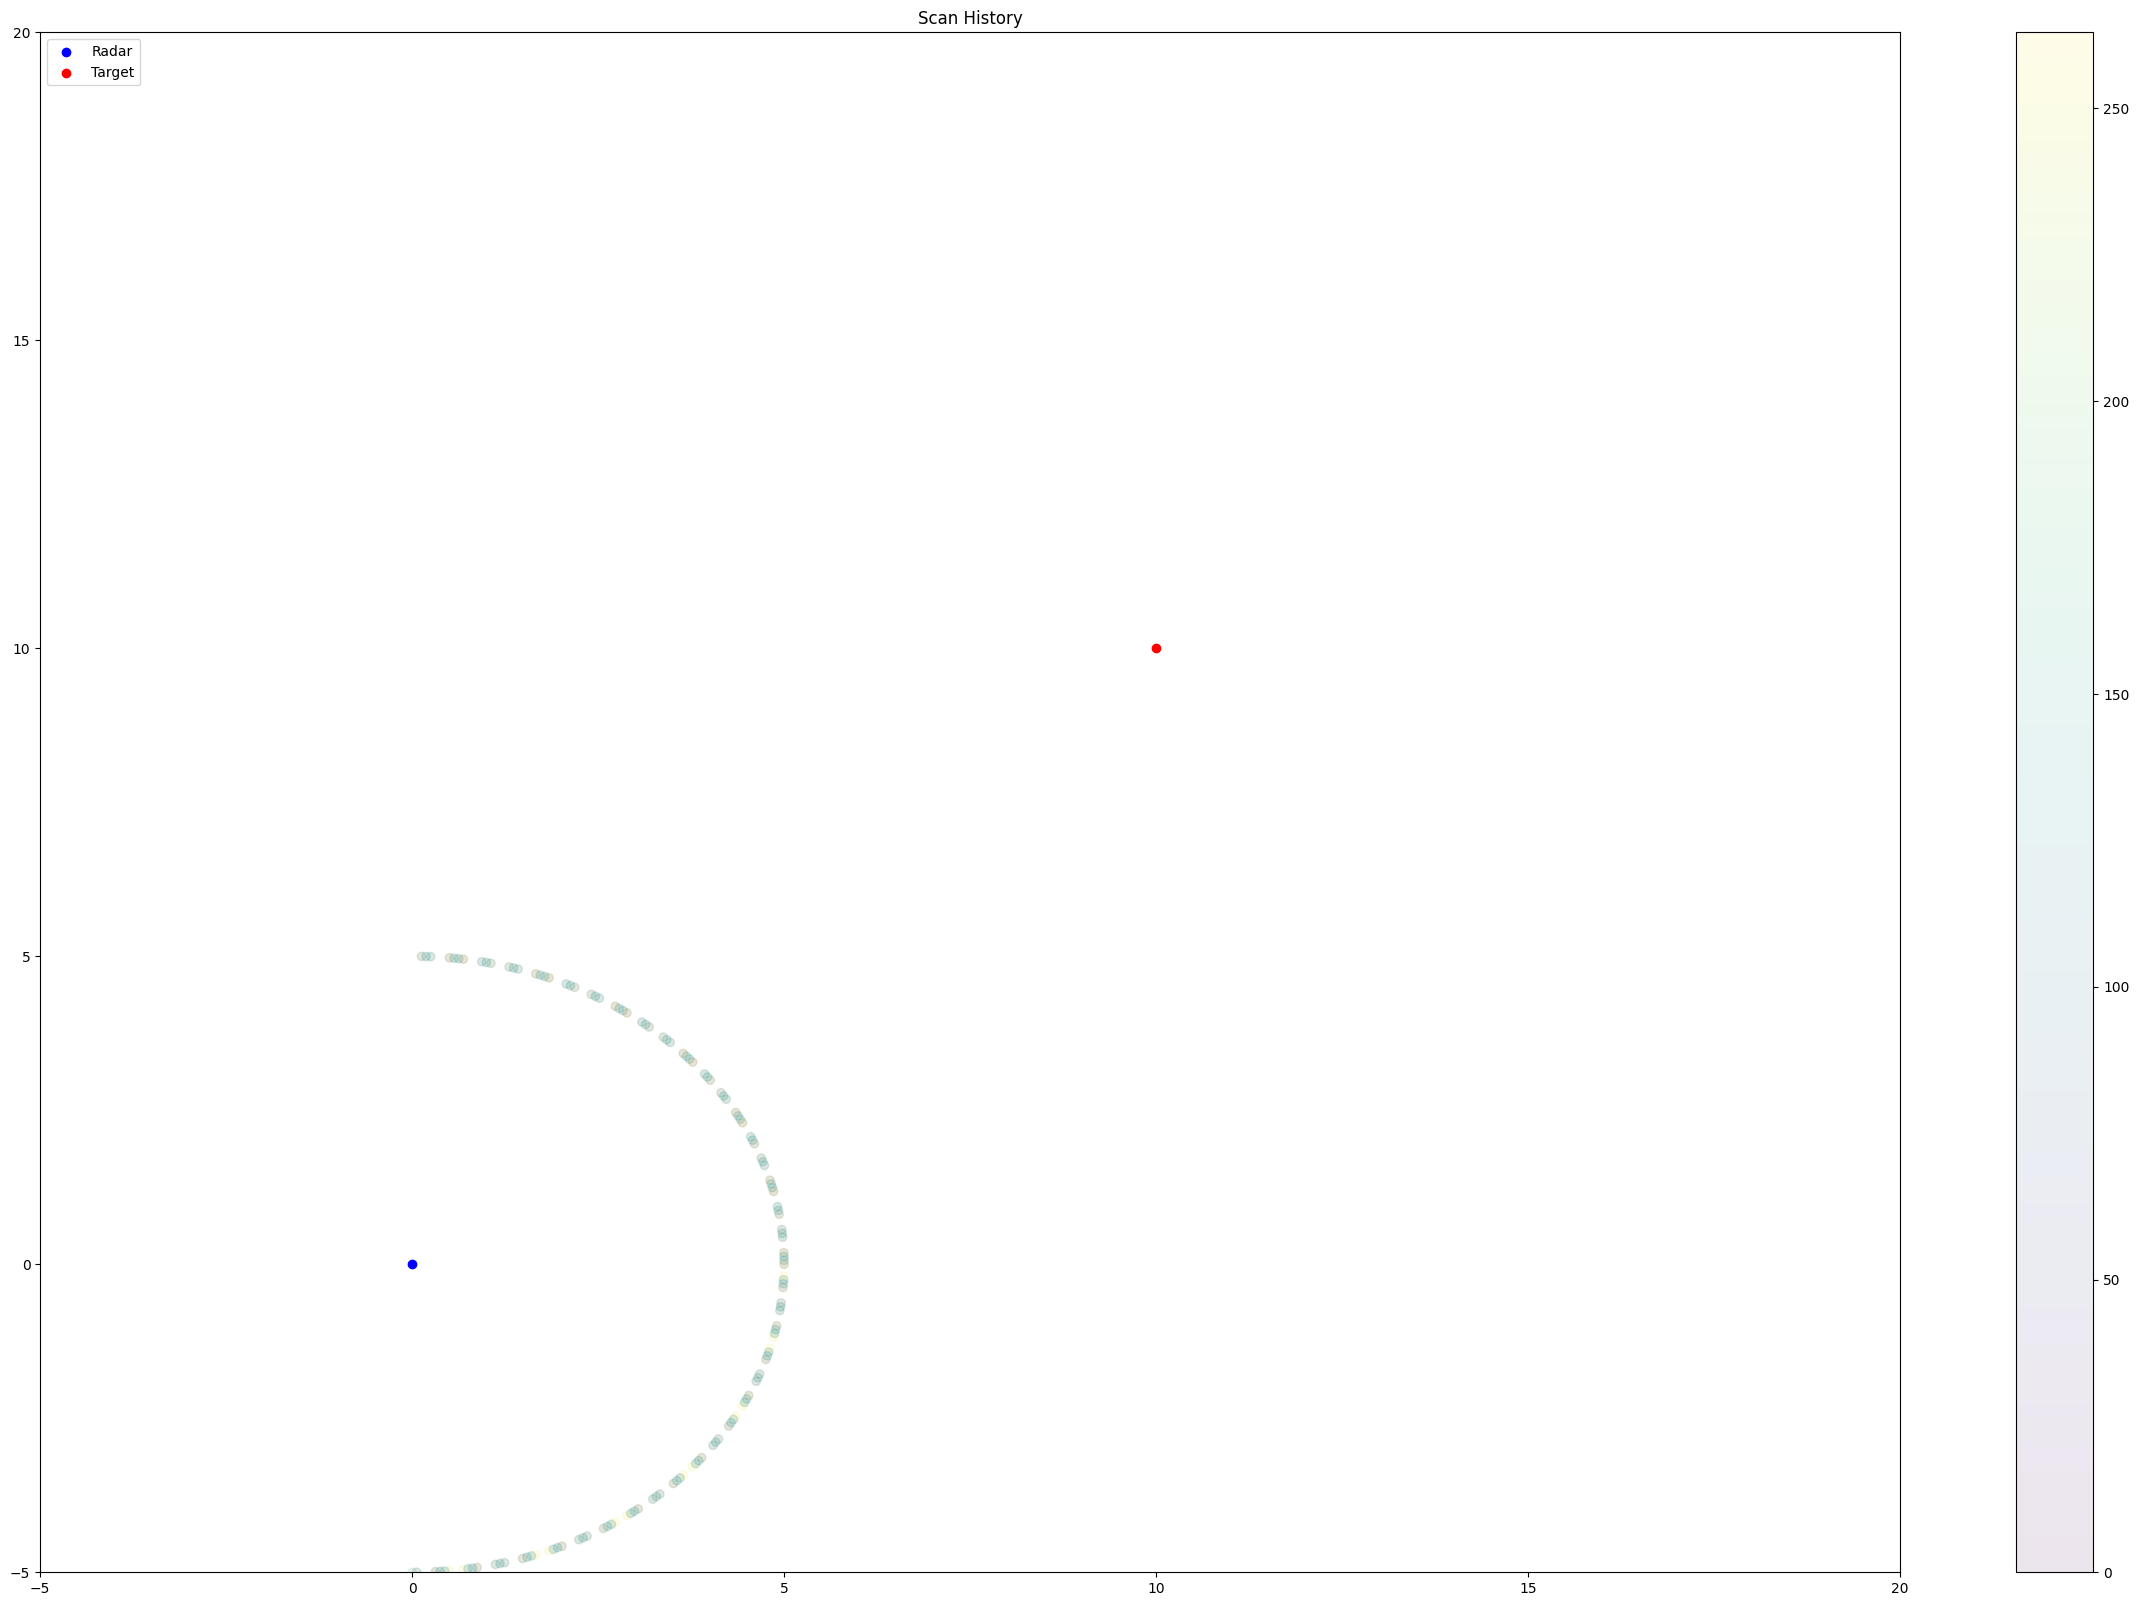

Sector Scan (180 degrees) w/ Static Target outside Scan Sector


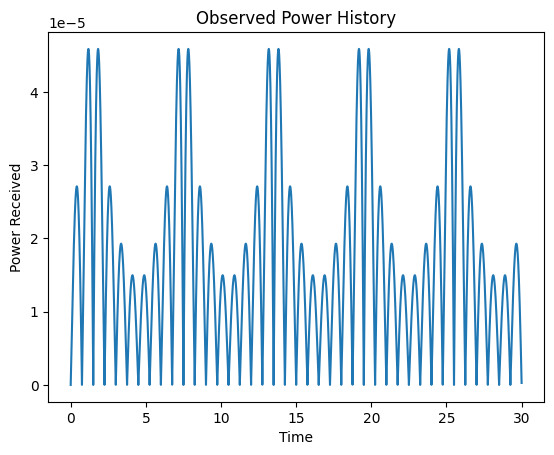

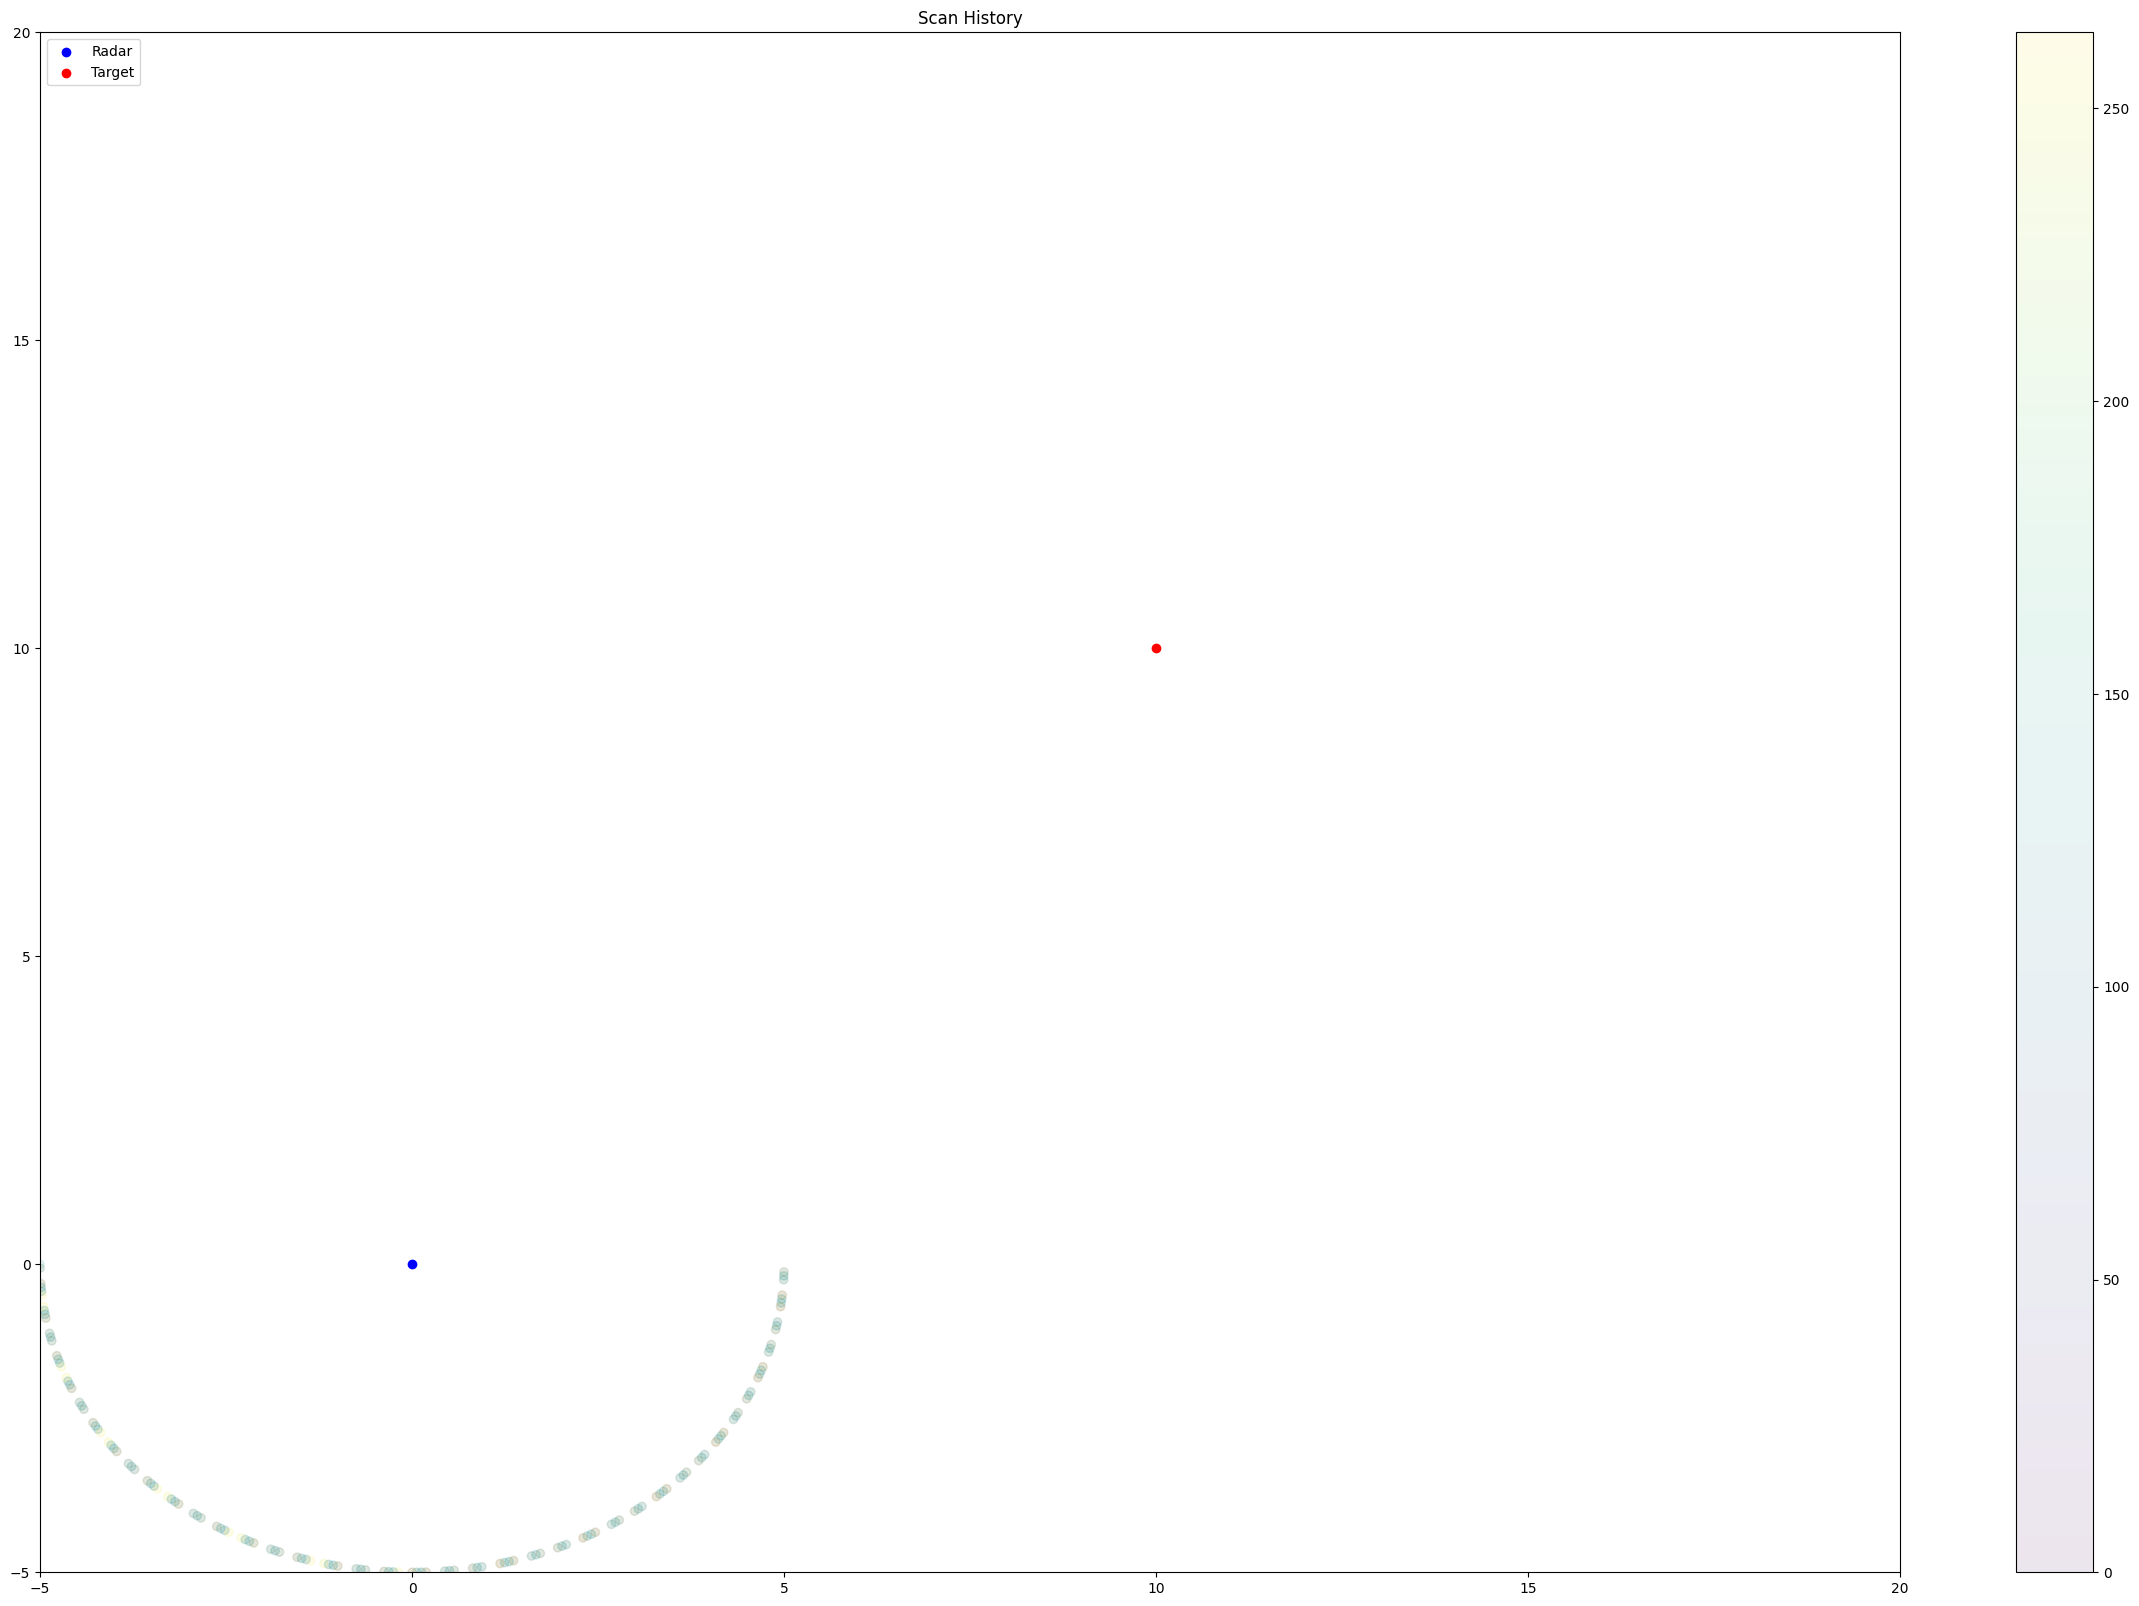

Sector Scan (90 degrees) w/ Static Target in Scan Sector


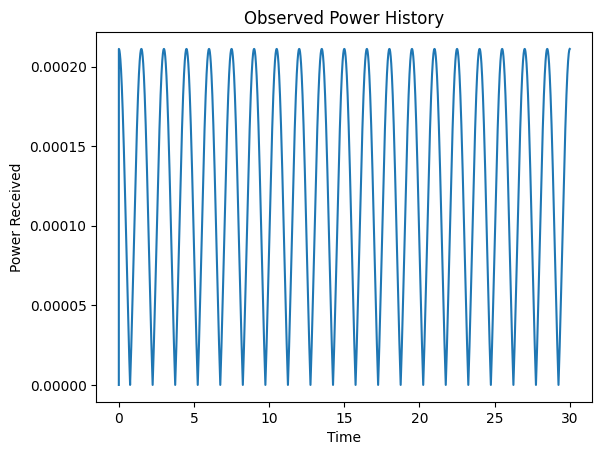

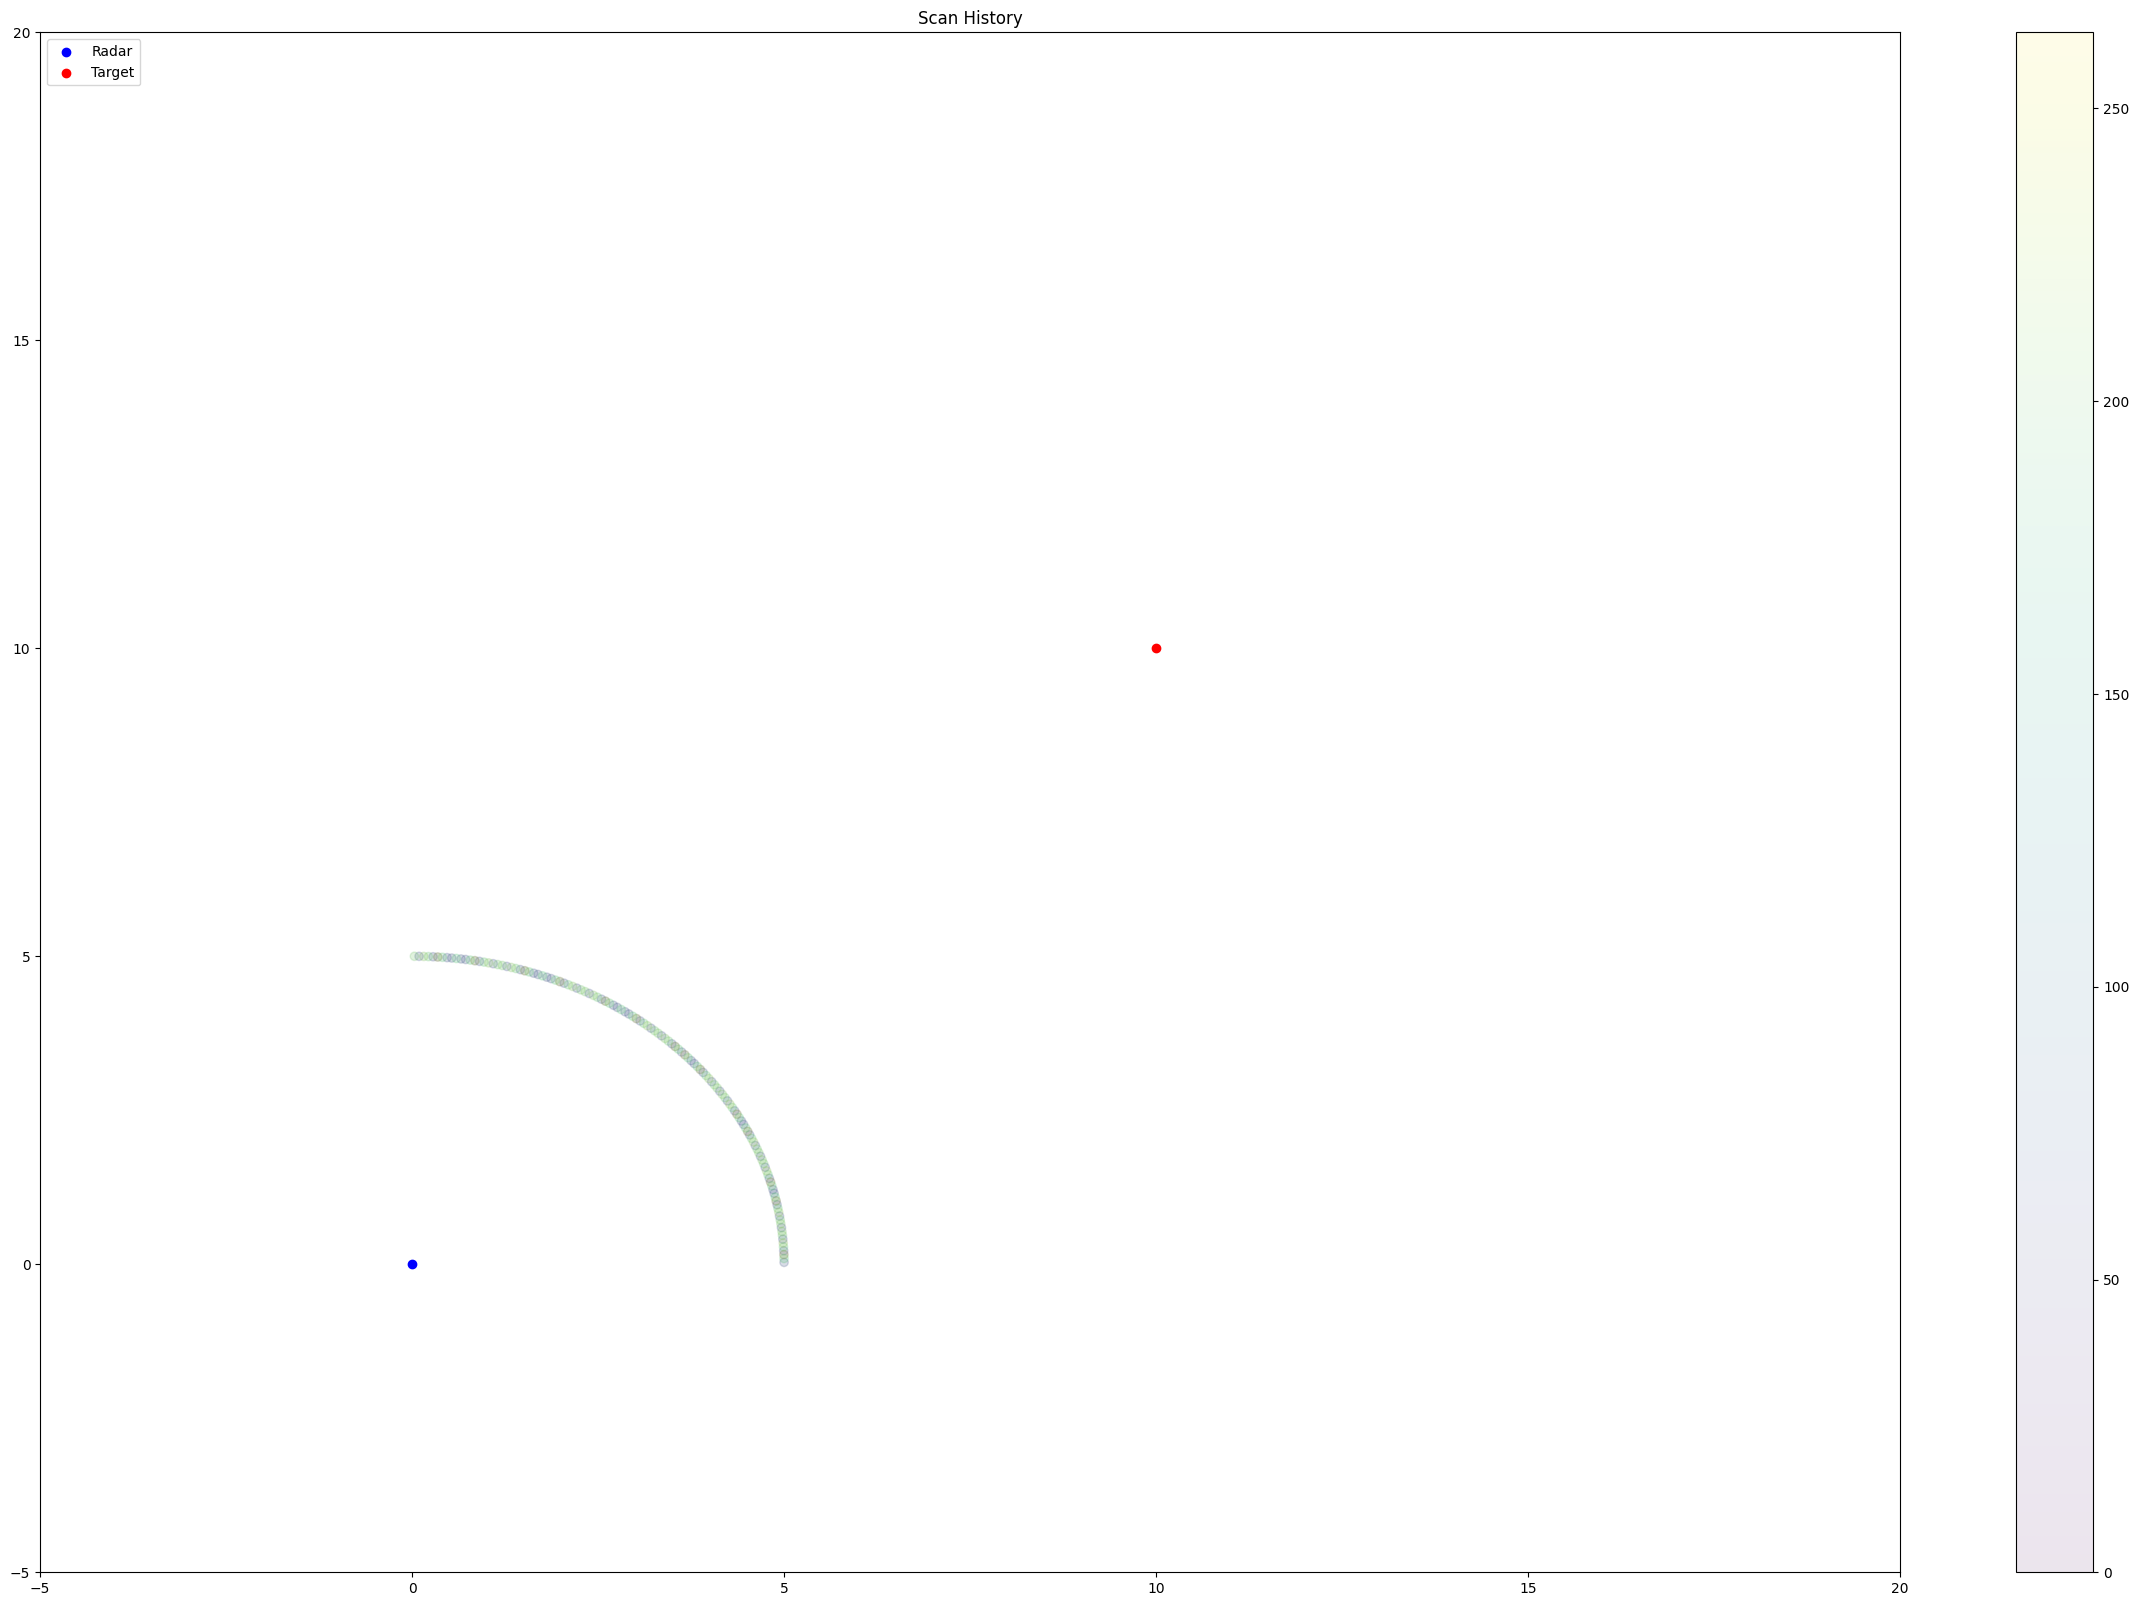

Sector Scan w/ Moving Target in Scan Sector


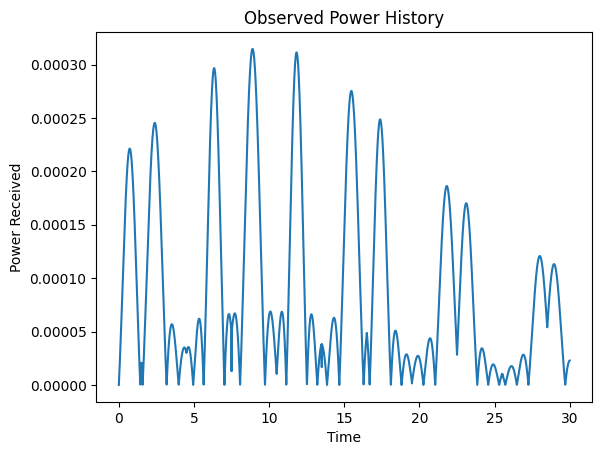

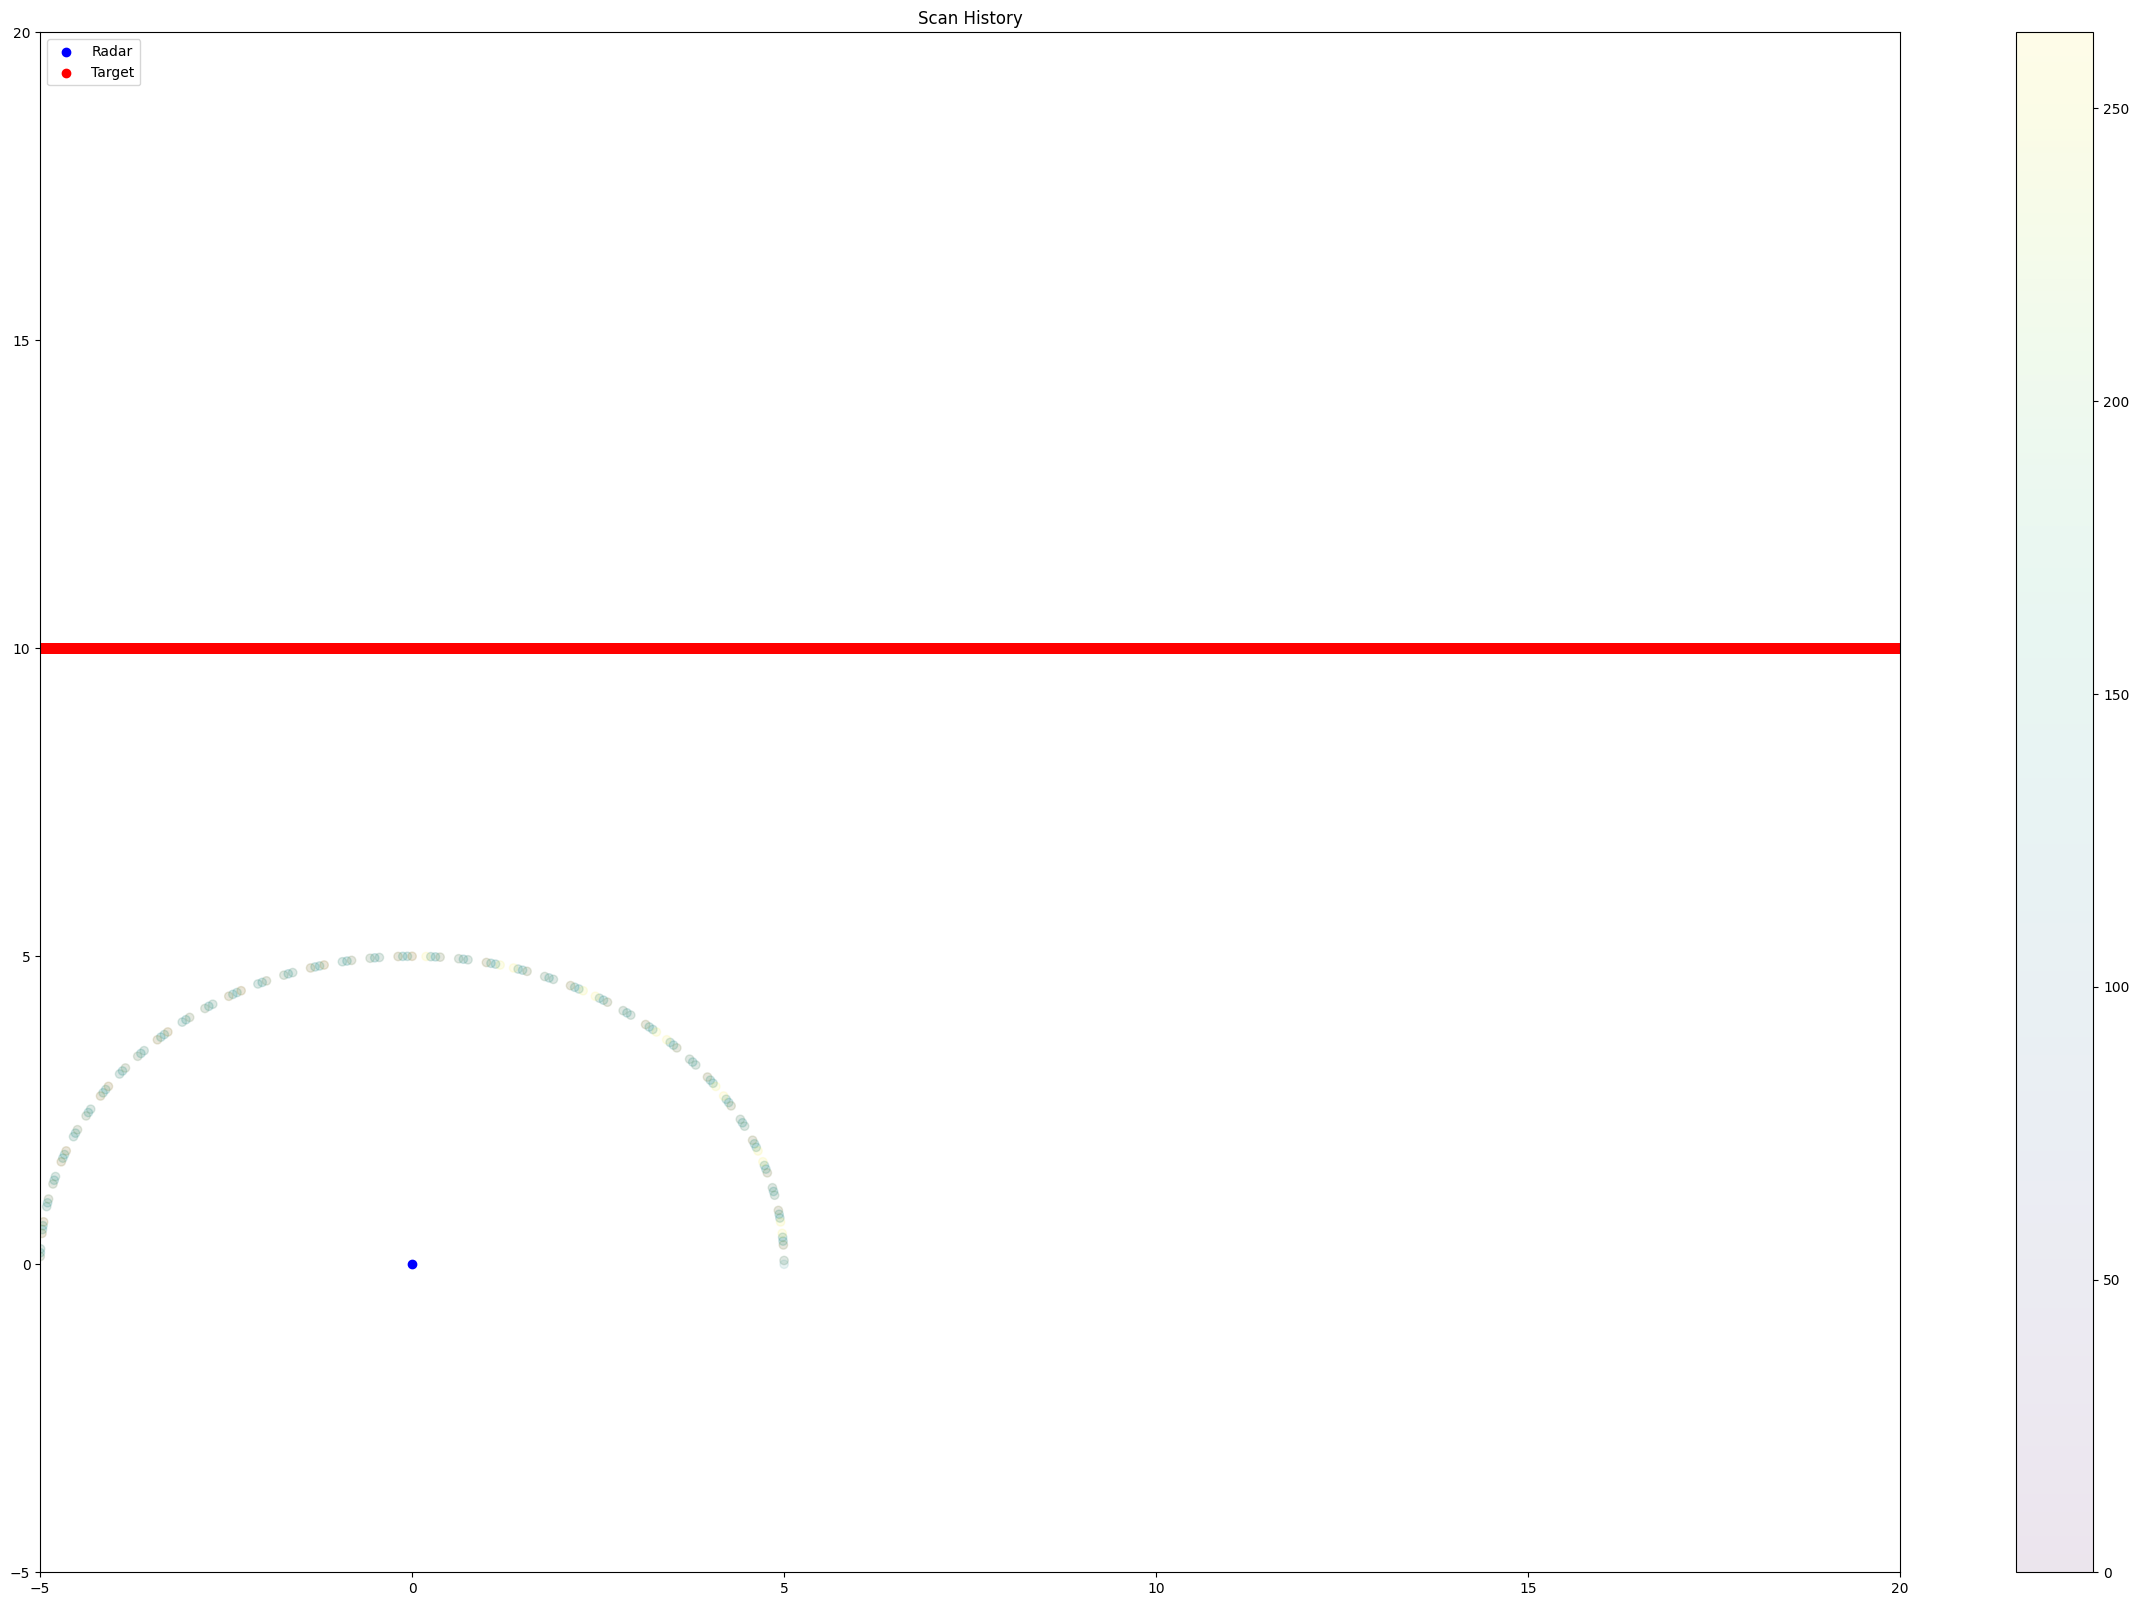

In [94]:
az_speed = 60
def sector_scan(starting_angle, scan_width):
    degrees = np.empty(len(t))
    degrees[0] = starting_angle
    direction = 1
    for i in range(len(t)-1):
        j = i + 1
        degrees[j] = degrees[i] + (t[j] - t[i]) * az_speed * direction
        if degrees[j] > degrees[0] + scan_width/2:
            degrees[j] = degrees[0] + scan_width/2
            direction = -direction
        elif degrees[j] < degrees[0] - scan_width/2:
            degrees[j] = degrees[0] - scan_width/2
            direction = -direction
        
    power = model_scan(degrees)

    for i in range(len(t)-1):
        j = i + 1
        degrees[j] = degrees[i] + (t[j] - t[i]) * az_speed * 2 * direction
        if degrees[j] > degrees[0] + scan_width/2:
            degrees[j] = degrees[0] + scan_width/2
            direction = -direction
        elif degrees[j] < degrees[0] - scan_width/2:
            degrees[j] = degrees[0] - scan_width/2
            direction = -direction
        
    show_power(power)
    show_2d(degrees)
    
# Static target
target.x = 10
target.z = 10

print("Sector Scan (180 degrees) w/ Static Target in Scan Sector")
sector_scan(0, 180)
print("Sector Scan (180 degrees) w/ Static Target outside Scan Sector")
sector_scan(270, 180)
print("Sector Scan (90 degrees) w/ Static Target in Scan Sector")
sector_scan(45, 90)

# Fast target moving right
target.x = -10
target.x += t * 1
target.z += t * 0

print("Sector Scan w/ Moving Target in Scan Sector")
sector_scan(90, 180)

# Raster Scan

Raster Scan w/ Static Target


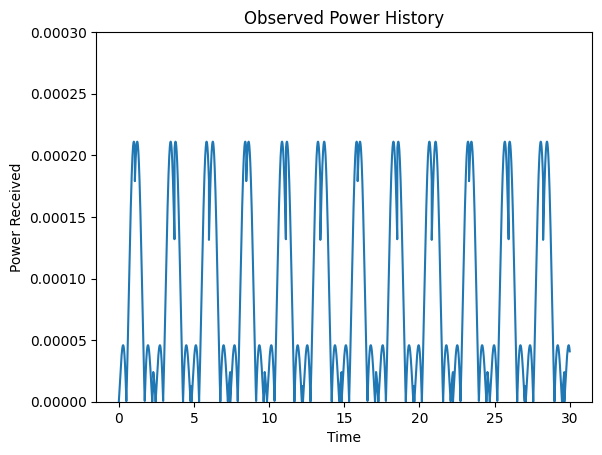

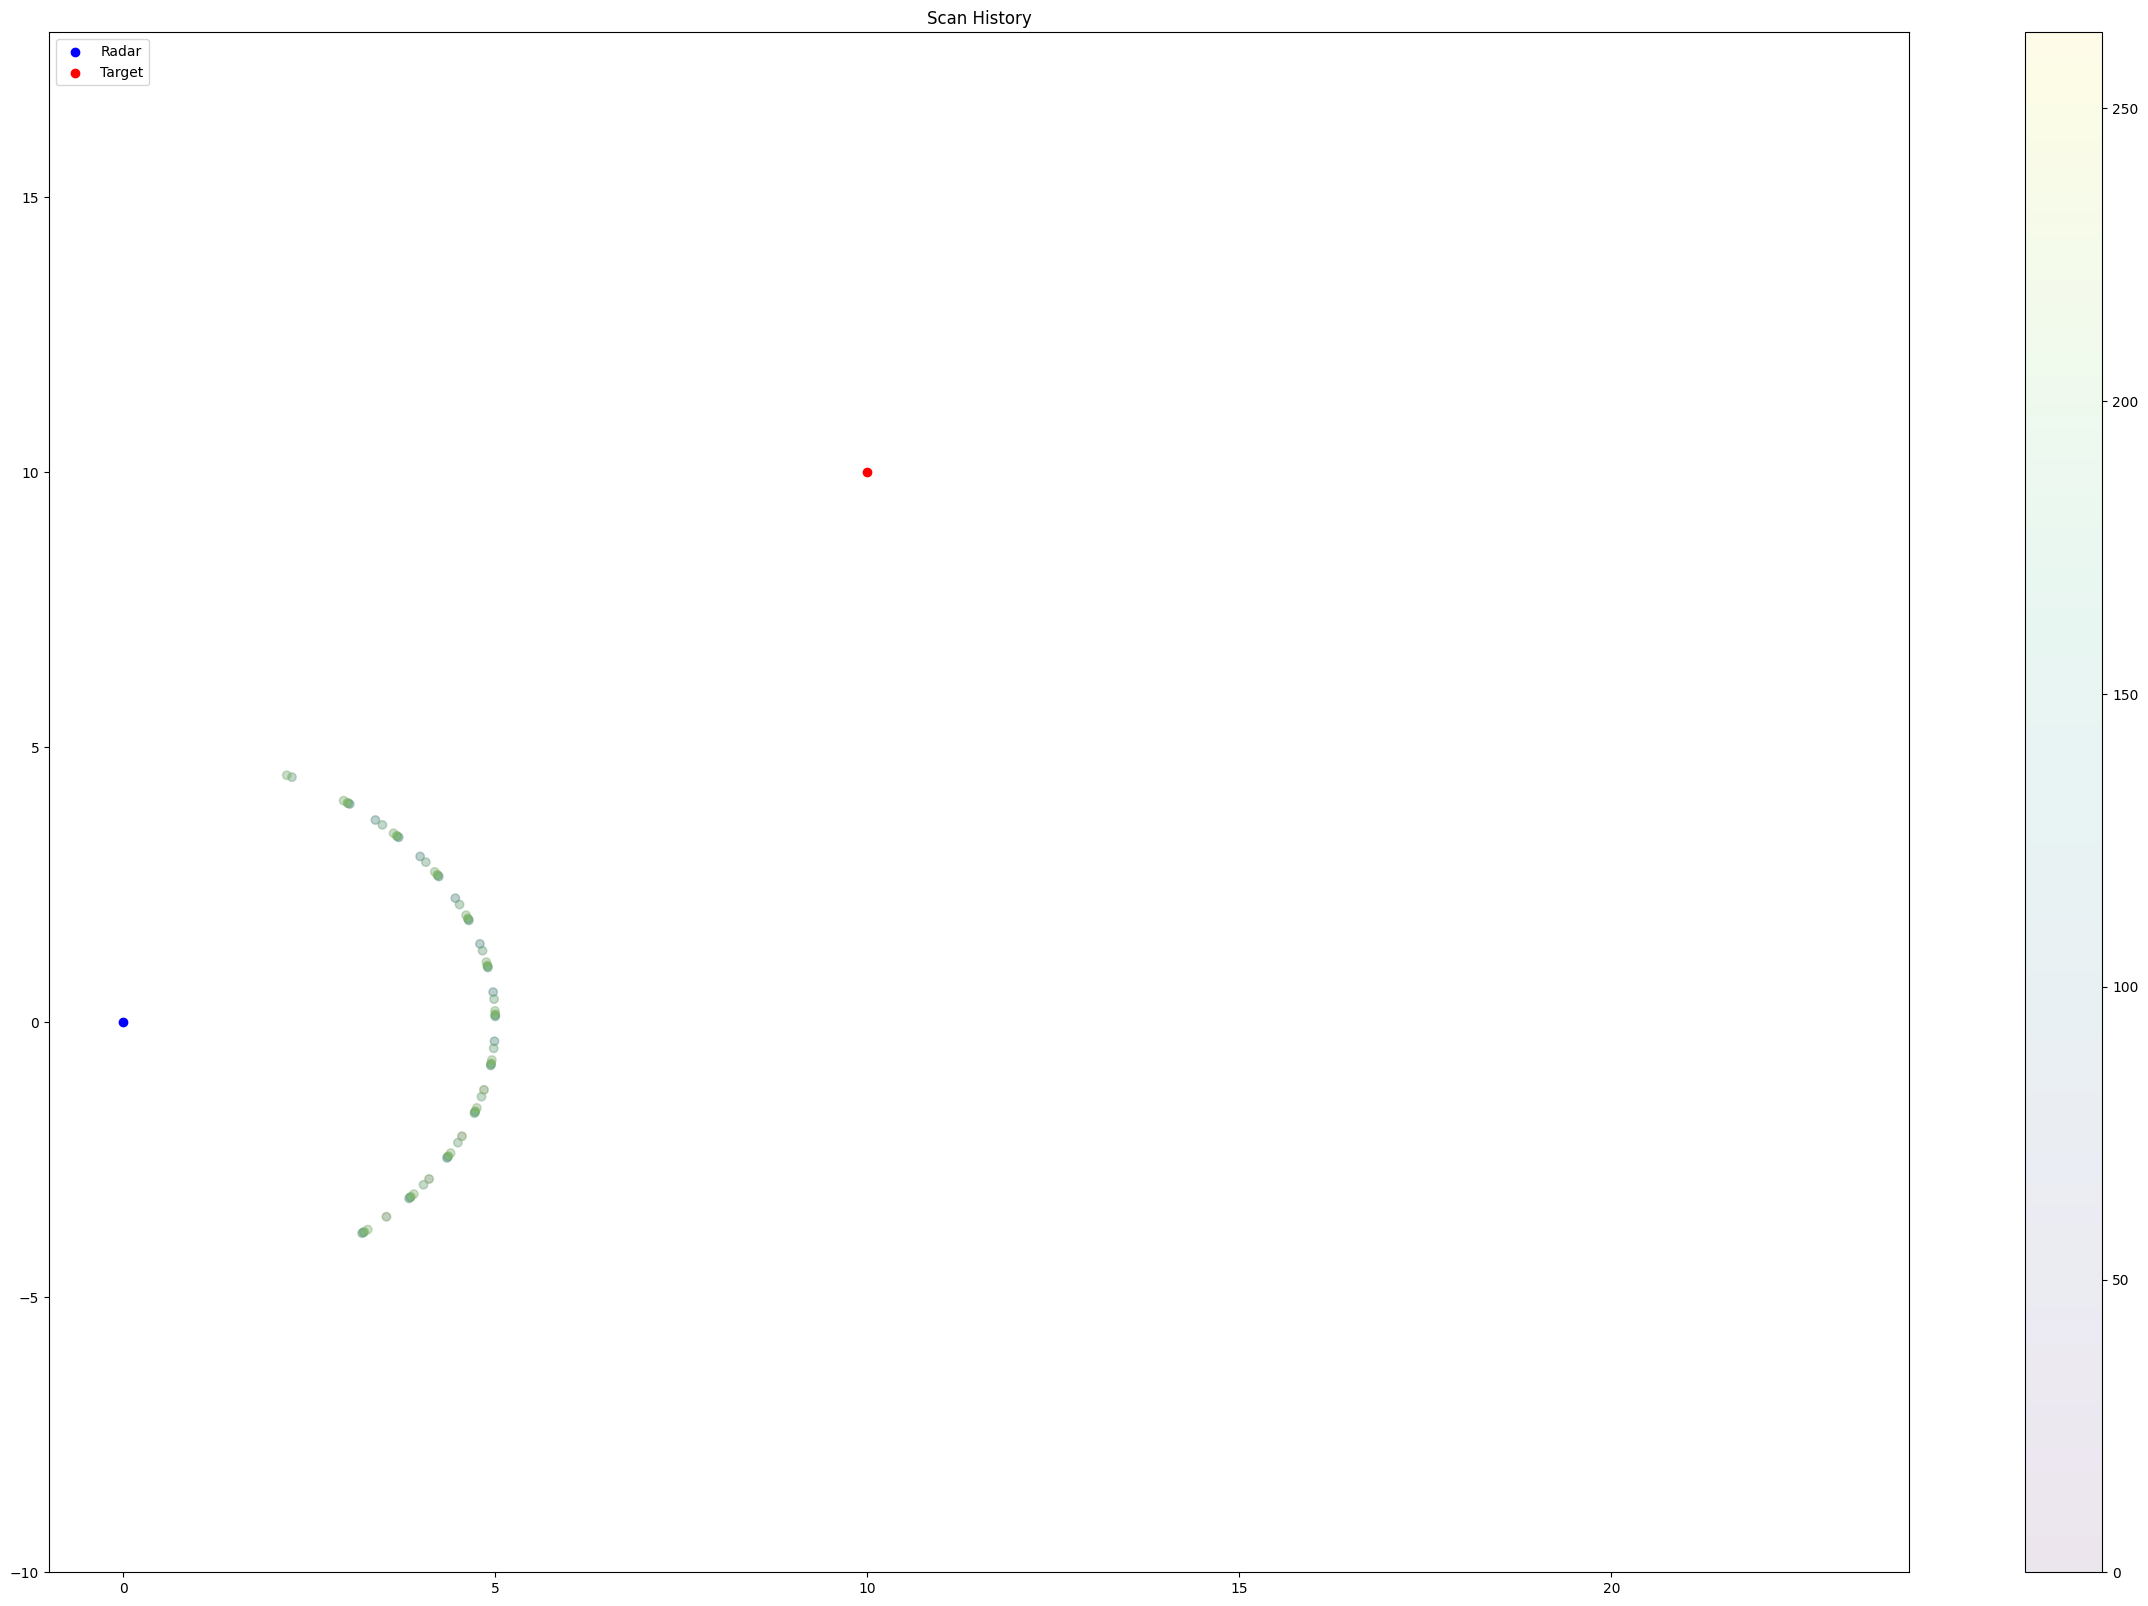

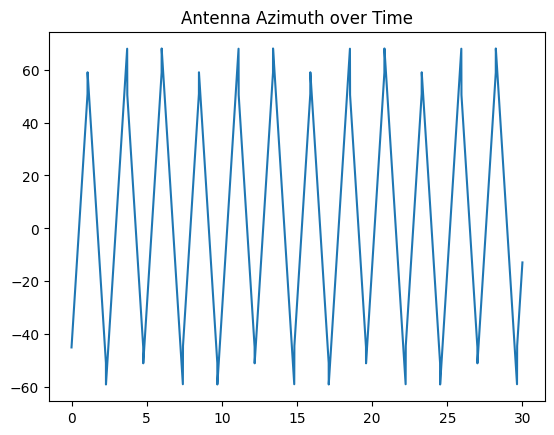

Raster Scan w/ Moving Target


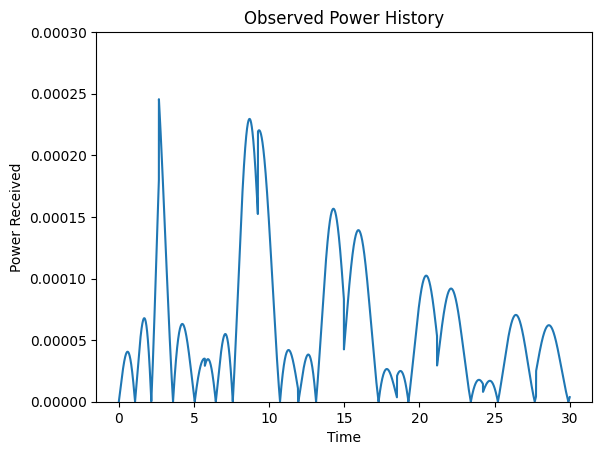

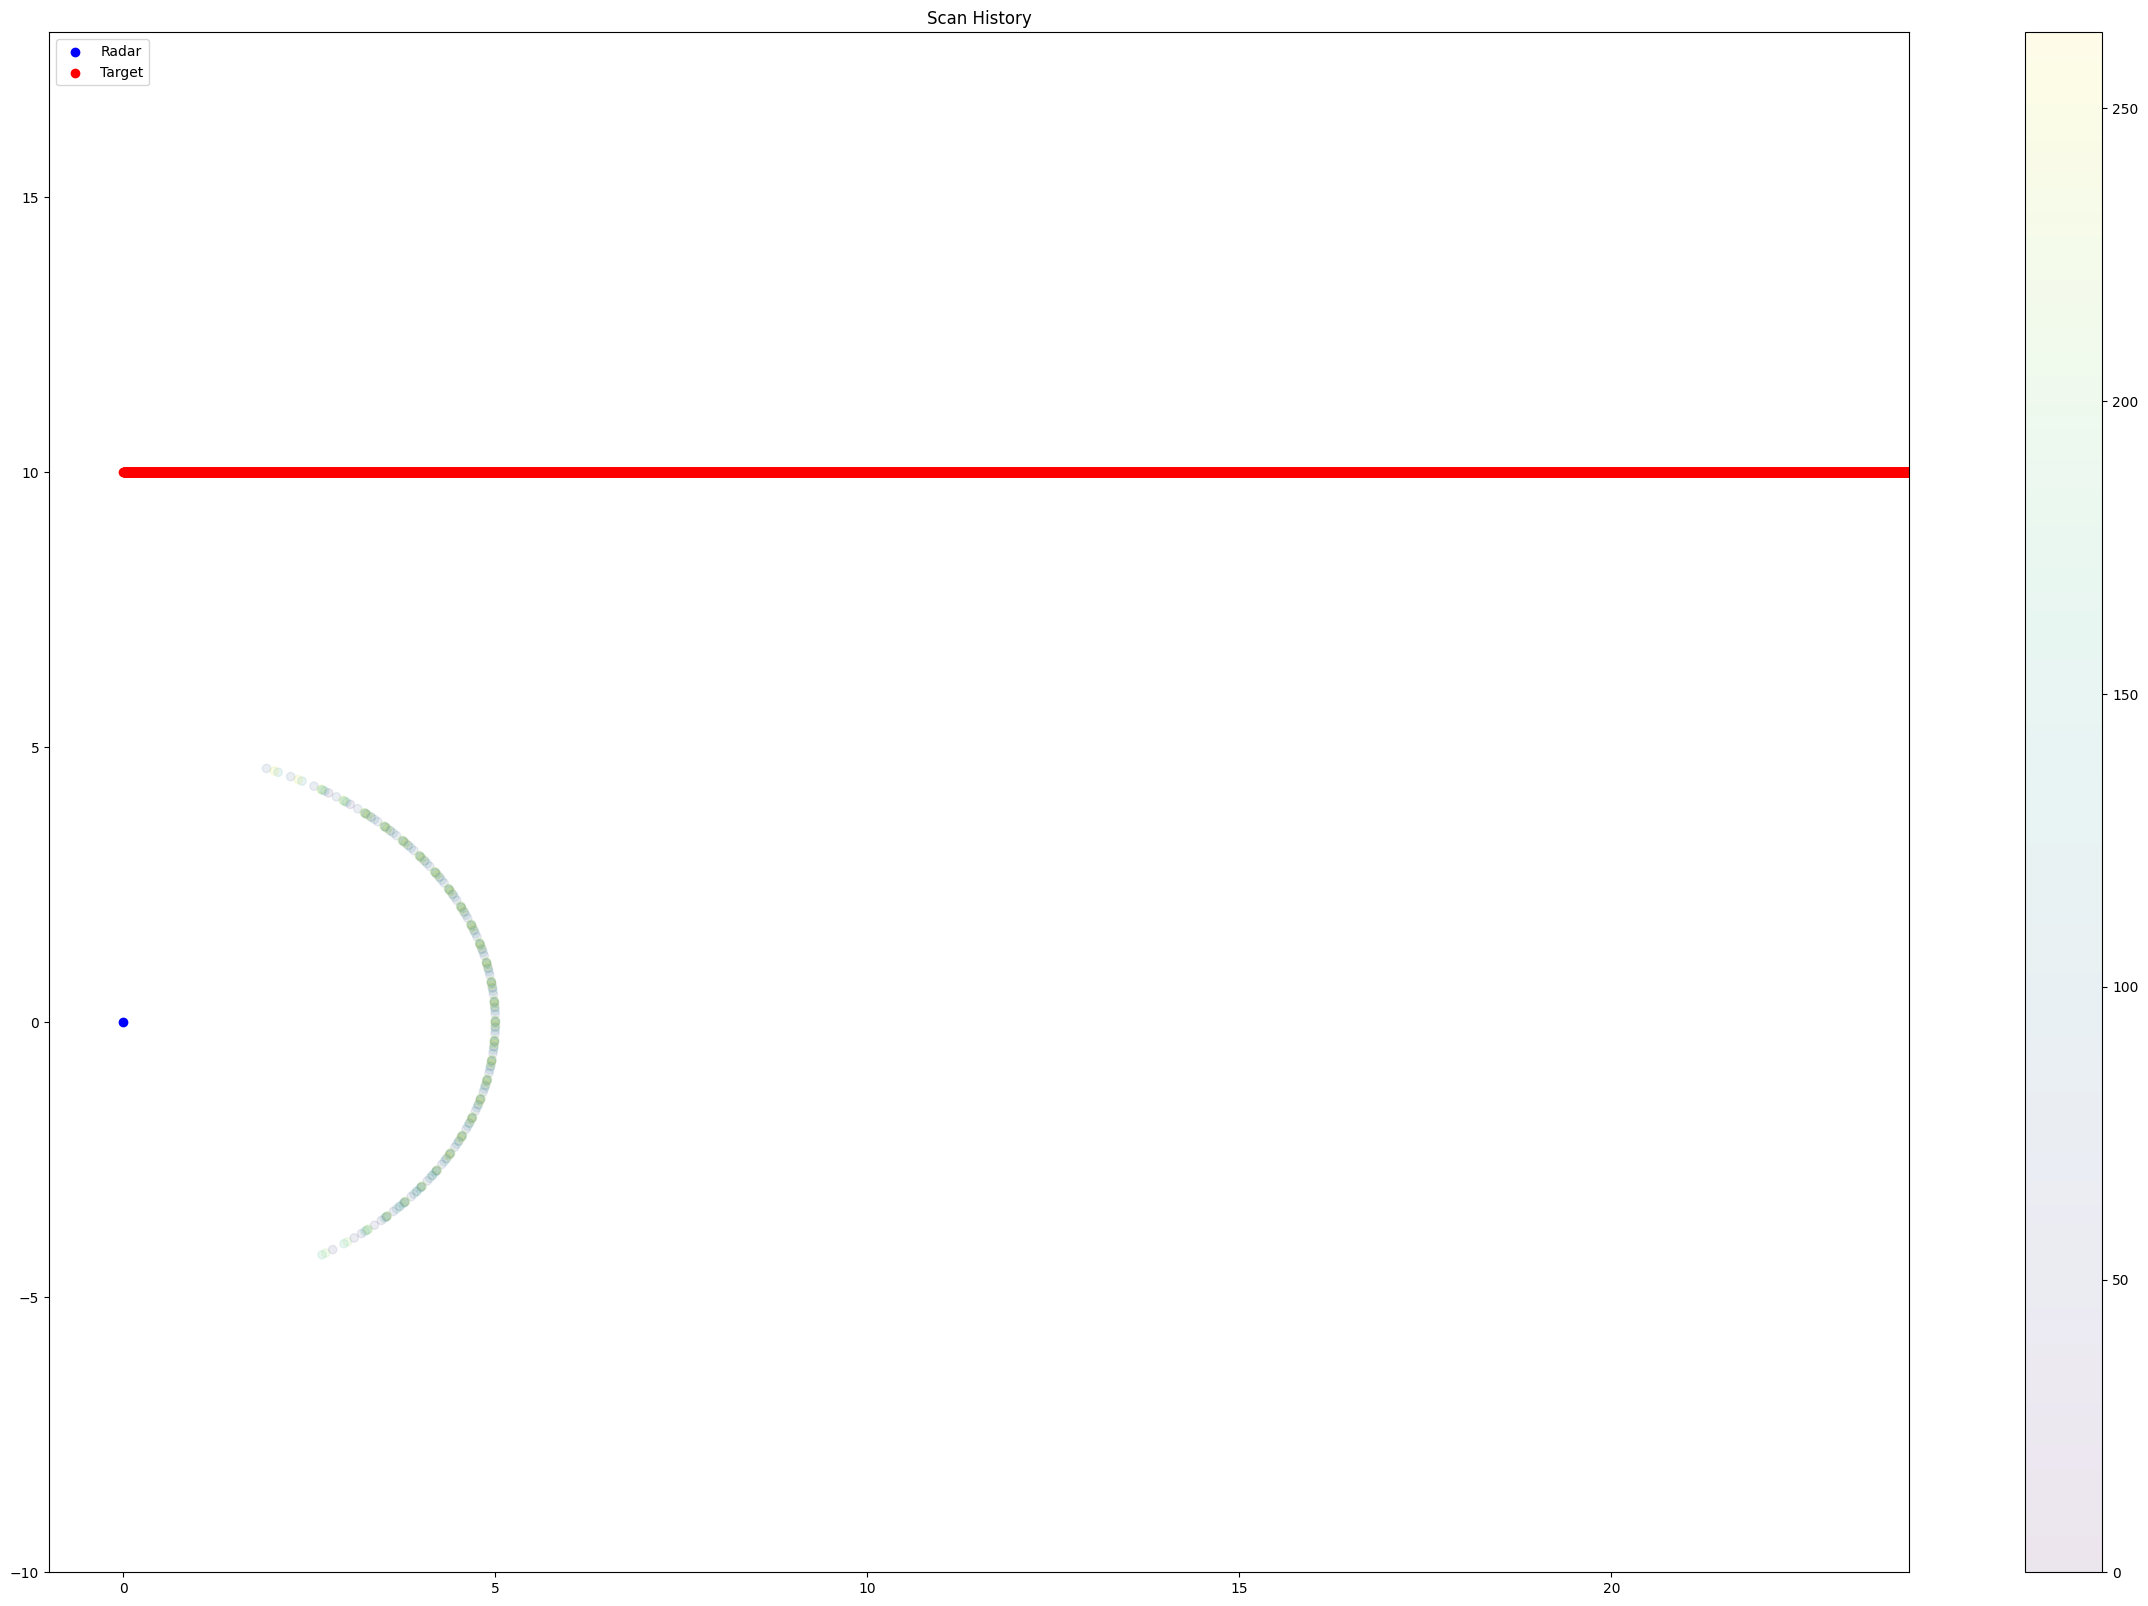

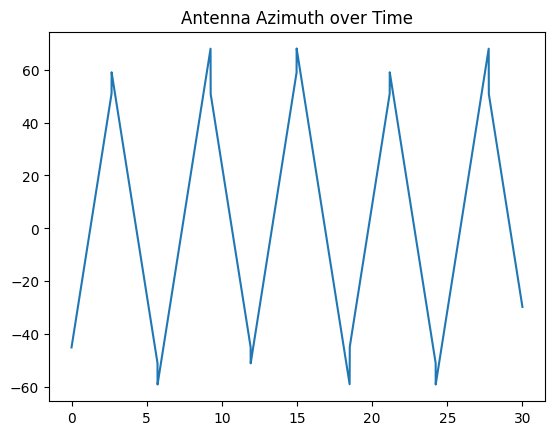

In [96]:
def show_power(power):
    plt.plot(t, power)
    plt.xlabel("Time")
    plt.ylabel("Power Received")
    plt.title("Observed Power History")
    plt.ylim(0, 0.0003)
    plt.show()
    
def raster_scan(grid_scale, angular_speed):
    row_left = [-45, -51, -59]
    row_right = [51, 59, 68]
    degrees = np.empty(len(t))
    degrees[0] = row_left[0]
    row_left = np.arctan(np.radians(row_left))
    row_left = np.degrees(np.tan(row_left))
    row_right = np.arctan(np.radians(row_right)) * grid_scale
    row_right = np.degrees(np.tan(row_right))
    current_direction = 1
    current_row = 0

    for i in range(len(t) - 1):
        j = (i + 1) % (len(t))
        degrees[j] = degrees[i] + angular_speed * (t[j] - t[i]) * current_direction
        if degrees[j] < row_left[current_row]:
            current_row = (current_row + 1) % 3
            degrees[j] = row_left[current_row]
            current_direction = -current_direction

        elif degrees[j] > row_right[current_row]:
            current_row = (current_row + 1) % 3
            degrees[j] = row_right[current_row]
            current_direction = -current_direction

    power = model_scan(degrees)
    show_power(power)
    show_2d(degrees, limits=[-1, 24, -10, 18])
    show_azimuth_history(degrees)
    
t = np.linspace(0, 30, time_samples)

# Static target

target.x = 10
target.z = 10
radar.x = 0
radar.z = 0

print("Raster Scan w/ Static Target")
raster_scan(1, 90)

# Moving target from right to left
target.x = 0
target.x += t * 1
target.z += t * 0

print("Raster Scan w/ Moving Target")
raster_scan(1, 36)

